# Neuron Ball & Stick Model with Electrical Synapse

Copyright © 2005-2022 Blue Brain Project/EPFL. This notebook is under a [LGPLv3](https://raw.githubusercontent.com/BlueBrain/MOOC-neurons-and-synapses-2017/master/LICENSE.txt) license.


This exercise was taken for the completion of the **EPFL Simulation Neuroscience Course**



## Introduction

* **Load** the NEURON simulator in Python
* Construct a **single compartmental electrical** model
* **Run a simulation**, record the membrane voltage of the model and inject an external current
* **Add ion channels** to the membrane of the model
* Extend the model with a simple **dendrite**
* **Add a synapse** to the model
* **Connect** two cells

In [2]:
# Install dependencies 
!pip install neuron 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.0 MB 5.2 MB/s 


The documentation of NEURON is available [here](https://www.neuron.yale.edu/neuron/docs).

Historically the NEURON simulator was controlled using the [HOC language](https://www.neuron.yale.edu/neuron/static/new_doc/programming/hocsyntax.html).
More and more scientists are switching to the Python interface of NEURON. In Python there is something called the [HOCObject](https://www.neuron.yale.edu/neuron/static/docs/help/neuron/neuron/classes/python.html#HocObject) which be accessed by 'h' property of the neuron module, and which contains the HOC functionality of NEURON. For example, to load the 'stdrun.hoc' file which contains some handy functionality one calls the HOC function load_file using:

In [76]:
# Imports 
import neuron
# Show matplotlib plots inline
%matplotlib inline 

In [77]:
print(neuron.h)
# Load external files
neuron.h.load_file("stdrun.hoc");

<TopLevelHocInterpreter>


 Initialize the simulator (clean slate)

In [78]:
neuron.h.stdinit();

It is important to know that all the values used in NEURON have a certain default unit. 
The list of the defaults can be accessed here: https://www.neuron.yale.edu/neuron/static/docs/units/unitchart.html

For now the most important ones are:
* **length**: micrometer (um)
* **time**: milliseconds (ms)
* **voltage**: millivolt (mV)
* **specific capacitance**: microfarad/cm2 (uf/cm2)

## Constructing a neuron consisting of one compartment

The basic structure of a cell in NEURON is a set of interconnected cylinders (called segments or compartments). Each of these cylinders represents an isopotential part of the cell. The segments between the branch points are grouped together in sections.

![Segments](https://bbp.epfl.ch/public/simneuromooc/images/TutBallStick/segments.jpg)

Figure adapted from: Schutter, E. D. (2009). Computational modeling methods for neuroscientists. [The MIT Press](https://mitpress.mit.edu/books/computational-modeling-methods-neuroscientists).

Our ball-and-stick model will look like this:

![ecircuit](https://bbp.epfl.ch/public/simneuromooc/images/TutBallStick/ballandstick_circuit.jpg)

Each sub-circuit represents an isopotential segment of the neuron (cylinder)

In [79]:
#First creating the Soma or the cell body object
soma = neuron.h.Section(name='soma')

print("Soma object:", soma)
print("Soma object name: ", soma.name())

print("Number of segments in the soma:", soma.nseg)

Soma object: soma
Soma object name:  soma
Number of segments in the soma: 1


In [80]:
#Setting the parameters of the soma which is represented as a cylinder 

soma.L = 40 #length
soma.diam = 40 #diameter
print("Soma length: %f micron" % soma.L)
print("Soma diameter: %f micron" % soma.diam) 

Soma length: 40.000000 micron
Soma diameter: 40.000000 micron


In [81]:
#One can calculate the area of the soma using func area()

#Area according to the formula of the area of a cylinder
soma_area_eq = 2 * neuron.h.PI * soma.L * soma.diam / 2
print("Soma area according to cylinder surface area equation: %f micron^2" % soma_area_eq)

#Area using the area() function 
# The 0.5 refers to the segment in the middle of the soma
# Because there is only one segment, in this case it refers to the entire soma
soma_area = neuron.h.area(0.5, sec=soma)
print("Soma area according to NEURON: %f micron^2" % soma_area)

print("Both values match: %s" % (soma_area_eq == soma_area))

Soma area according to cylinder surface area equation: 5026.548246 micron^2
Soma area according to NEURON: 5026.548246 micron^2
Both values match: True


In a real neuron the soma of a neuron is rather spherical than cylindrical.  However, the following equation shows that it actually doesn't really matter, the surface area of a sphere with the same radius is exactly the same:

In [82]:
soma_sphere_area_eq = 4 * neuron.h.PI * pow(soma.diam / 2, 2)
print("Soma area according to sphere surface area equation: %f micron^2" % soma_sphere_area_eq)

Soma area according to sphere surface area equation: 5026.548246 micron^2


So now we have defined the shape of this single compartmental cell. Electrically the only component that is present for now is the [capacitance] $C_m$ (https://en.wikipedia.org/wiki/Capacitance) of the cell membrane. We can retrieve or set the specific membrane capacitance by accessing the 'cm' field. The units of this field are microFarad per cm2. You will see that in NEURON most quantities related to the surface currents are specified per membrane surface area. To obtain the total capacitance of the entire cell, one must multiply the specific capacitance by the total surface area. 

In [83]:
print("Specific capacitance: %f uf/cm2" % soma.cm)

#To get the total capacitance of the soma, we have to multiply this by the surface area.
soma_tcap = (soma.cm * (soma_area / pow(1e4, 2)))
print("Total soma capacitance: %f uf" % (soma.cm * (soma_area / pow(1e4, 2))))

Specific capacitance: 1.000000 uf/cm2
Total soma capacitance: 0.000050 uf


### Performing simulations (electrophysiology) on the soma.

Performing simulations allow us to observe the behavior of the neuron relative to electrical stimulation.

In [84]:
#Print current membrane voltage
print("Membrane voltage soma: %f mV" % soma(.5).v) # mV

Membrane voltage soma: -65.000000 mV


As you can see the voltage of the cell has been initialised to -65 mV, which roughly corresponds to a typical value in neurons at rest (also called the *resting membrane potential*).


The simulator will integrate the equations over time. The current time is saved in a variable called 't':

In [85]:
print("Current time: %f ms" % neuron.h.t) # ms

Current time: 0.000000 ms


When the run() function is called, the simulation will run until a predefined time stored in the the 'tstop' variable. Every timestep, defined by 'dt', a new voltage value will be calculated. 

### **Neuron at rest**

Only the normal capacitance (no channels open at all)

In [86]:
#Setting simulation parameters (time and dt)

neuron.h.tstop = 100
print("Simulation stop time: %f ms" % neuron.h.tstop)
print("Integration time step: %f ms" % neuron.h.dt)

Simulation stop time: 100.000000 ms
Integration time step: 0.025000 ms


To record the time and voltage we create two NEURON Vector objects. These objects have a 'record' method that, when passed a reference to a variable, will record the value of that variable in the vector during the simulation.

In [87]:
#Create time and voltage vector objects to record time and voltage
time = neuron.h.Vector()
voltage = neuron.h.Vector()

time.record(neuron.h._ref_t)
voltage.record(soma(.5)._ref_v);

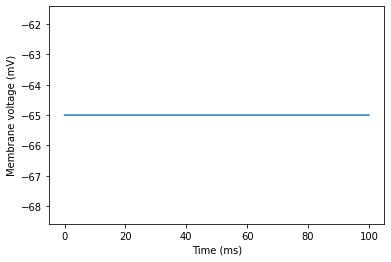

In [88]:
#Run simulation given only time parameter. All t and V will be recorded.
#Note that we did no perturbation or introduced no current at this point

neuron.h.run()

#Plot voltage over time
def plot_tv(time_array, voltage_array, show=True, label=None, constants=[]):
    import matplotlib.pyplot as plt
    import numpy
    plt.plot(time_array, voltage_array, label=label)
    for constant in constants:
        plt.plot(time_array, constant*numpy.ones(len(time_array)))
    plt.xlabel('Time (ms)')
    plt.ylabel('Membrane voltage (mV)')
    if show:
        plt.show()
    
plot_tv(time, voltage)

The voltage has stayed the same over time
. We can see why this happened by looking at the following equation NEURON is integrating:

$$C_{m} \frac{dV}{dt} = I_{m}$$

Basically the change in voltage is related to the current going across the membrane. Since we don't have any mechanisms that allow currents to cross the membrane, $I_{m}$ is zero, and our voltage stay the same:

$$dV = I_{m} \frac{dt}{C_{m}} = 0 \frac{dt}{C_{m}}$$

### **Injecting a current**

This time we charge the cell membrane capacitance. Similar to the experiment done by Hodgkin & Huxley on a squid neuron, only we do it virtually, by sticking a virtual electrode in the center of the soma, and injecting current using a [current clamp](https://en.wikipedia.org/wiki/Electrophysiology#Current_clamp). 

We specify an **amplitude (in nA)**, a **delay** and a **duration** for our stimulus.

In [89]:
iclamp = neuron.h.IClamp(.5, sec=soma)
iclamp.amp = 0.1 # nA
iclamp.delay = 10 # ms
iclamp.dur = 50 # ms

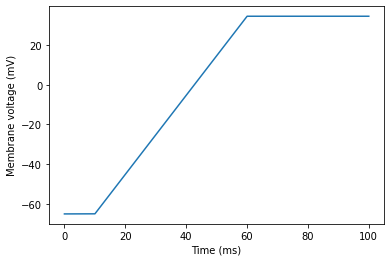

In [90]:
neuron.h.run()

plot_tv(time, voltage)

This time, by injecting a current in the center of the soma, we observe a ramp / a change in voltage (increase) between 10-50ms based on the equation: 

$$C_{m} \frac{dV}{dt} = I_{m}$$

Below, we check if the theoretical result given initial current parameters are equal to what is observed. 




In [91]:
V1 = -65 # Voltage before stimulus, mV
V2 = soma.v # Voltage after stimulus, mV
deltaV = V2 - V1 # Voltage difference, mV

Im = iclamp.amp # Initial current injected nA
deltaT = iclamp.dur # Duration of current ms
soma_tcap # Total soma membrane capacitance, uF

deltaV_eq = Im * deltaT / soma_tcap # in nA * ms / uF == microvolt
deltaV_eq /= 1e3 # Correction factor to get mV

print('Observed dV: %f mV' % deltaV)
print('Calculated dV: %f mV' % deltaV_eq)
print('Simulated dV matches equation dV: %s' % (deltaV - deltaV_eq < 1e-6))

Observed dV: 99.471839 mV
Calculated dV: 99.471839 mV
Simulated dV matches equation dV: True


### **Adding a leak conductance**

To comparably simulate the Hodgkin & Huxley model, we add leak conductance to simulate open channels. 

We'll now start adding transmembrane currents to the model as described in the [Hodgkin-Huxley model](https://en.wikipedia.org/wiki/Hodgkin–Huxley_model).
To enable the equations for this model, we insert the 'hh' mechanism in the soma:

In [92]:
soma.insert('hh'); #hh for hodgkin-huxley model

Now NEURON will integrate the following equation to get calculate the membrane voltage over time:

$$C_{m} dV/dt = -(I_{Na} + I_{K} + I_{leak}) + I_{ext} = -(g_{Na}(V)*(V - E_{Na}) + g_{K}(V)*(V - E_{K}) + g_{leak}*(V - E_{leak})) + I_{ext}$$

We have a **sodium and potassium current with voltage dependent conductance** and a *leakage current with a voltage independent conductance*.

In [93]:
#Initially setting the Na and K channels 
soma.gkbar_hh = 0.0
soma.gnabar_hh = 0.0

Membrane conductance when none of the voltage-dependent channels are open are only due to the leaky currents (resting membrane):

$$C_{m} \frac{dV}{dt} = -(g_{leak}*(V - E_{leak})) + I_{ext}$$


The value for the leak conductance is set using the 'gl_hh' attribute ('hh' refers to the name of the mechanism, 'gl' to the name of the parameter inside the 'hh' description). 

In [94]:
soma.gl_hh = 5e-4 # Leak conductance, S/cm^2

The 'el_hh' attribute sets the reversal potential. We call this the 'reversal' potential because the value responses the membrane voltage at which the leak current changes polarity. It's the potential towards this channel 'pushes' the membrane voltage. Let's set the value equal to the resting membrane potential of the cell, so that we have a force that tries to maintain the -65 mV.

In [95]:
el = soma.el_hh = -65 # Reversal potential leak current, mV
print("Reversal of leak current: %f mV" % el)

Reversal of leak current: -65.000000 mV


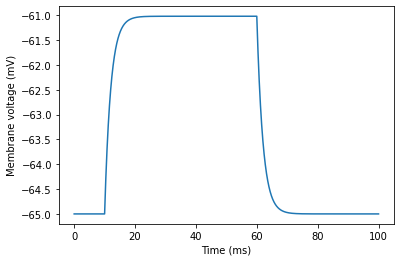

In [96]:
soma.gkbar_hh = 0.0
soma.gnabar_hh = 0.0

neuron.h.tstop = 100

neuron.h.run()

plot_tv(time, voltage)

## Exercise 1

**Question**: Compare this graph to the previous one (section "Injecting a current"). If you look at the equation, do you understand why the voltage flattens out at the end of the stimulus ? 

**Answer** : As you can observe in the plot, unlike the ramp voltage we saw earlier, when we allow the presence of leaky channels (as in a typical neuronal membrane, these are the open channels that are non-voltage dependent), we observe a steep increase in the membrane potential upon stimulation but due to the reversal potential (the leaky channels which bring back and maintain the resting potential), the sudden increase eventually goes constant then back to the membrane potential (-65mV) when the stimulation is gone. As mentioned these are open channels, thus any ion imbalance initiated by the injection of the current crosses back to maintain the resting membrane potential. 

**Exercise**: When you assume the time derivative of the voltage is zero in the interval between 40 and 60 ms. Calculate the average voltage in that interval. When you do your calculate beware of the units ! Also remember to multiply gl_hh by the surface area of the soma to get the total conductance.

**Answer**: 
This equation dictates the behavior of the membrane. 

$$C_{m} \frac{dV}{dt} = -(g_{leak}*(V - E_{leak})) + I_{ext}$$


In [97]:
Iext = iclamp.amp # Initial current injected nA
gleak = (soma.gl_hh * (soma_area / pow(1e1, 2)))
eleak = el

V_40 = -(-Iext / gleak) + eleak

average_V = V_40
print('Calculated ave V: %f mV' % average_V)

Calculated ave V: -61.021126 mV


Since the leaky current is non-voltage dependent, equating the left-hand side to zero, we get the voltage at 40s. During this time until 60s, we get an average voltage of -61.02mV.

### **Adding active ion channels**

To fully simulate the Hodgkin & Huxley model, we now add the voltage-dependent sodium and potassium channels. 

$$C_{m} dV/dt = -(I_{Na} + I_{K} + I_{leak}) + I_{ext} = -(g_{Na}(V)*(V - E_{Na}) + g_{K}(V)*(V - E_{K}) + g_{leak}*(V - E_{leak})) + I_{ext}$$

The conductance $g_{Na}$ and $g_{K}$ are decomposed in $\overline{g}_{Na} m^3$ and $\overline{g}_{K} h$. The gnabar and gkbar are parameters of the model that are expressed in siemens/cm^2. They basically represent the density of the ion channels on the membrane. Let's set these to a value different than 0.
When we then run the model, we see that the model now generates action potentials.

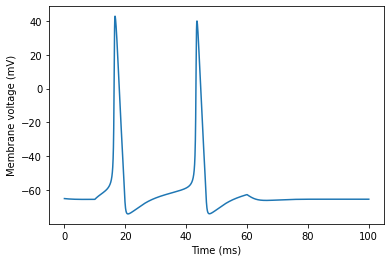

In [98]:
#Ion channel densities
soma.gkbar_hh = 0.01 # in S/cm^2 potassium
soma.gnabar_hh = 0.1 #sodium

neuron.h.run()

plot_tv(time, voltage)

To explain what happened, we can have a look at the reversal potentials of Na, K and leak currents:

Na reversal: 50.000000
K reversal: -77.000000
Leak reversal: -65.000000


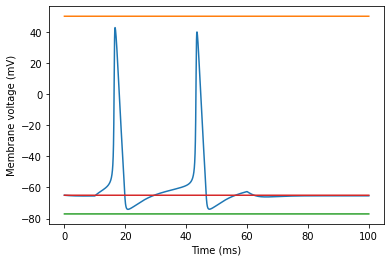

In [99]:
ena = soma.ena # explain e_na
ek = soma.ek
el = soma.el_hh

print("Na reversal: %f" % ena)
print("K reversal: %f" % ek)
print("Leak reversal: %f" % el)

plot_tv(time, voltage, constants=[ena, ek, el])

The three horizontal lines show the reversal potentials. During an action potential the positive ena pulls the membrane potential to 50 mV, but after awhile it gets inactivated and the potassium kicks in to pull the voltage back towards -77 mV. When the cell is at rest, the el keeps the membrane voltage around -65 mV.

### **Parameter sensitivity**

Studying the effect of different parameters on the action potentials generated.

In [100]:
import matplotlib.pyplot as plt
import numpy

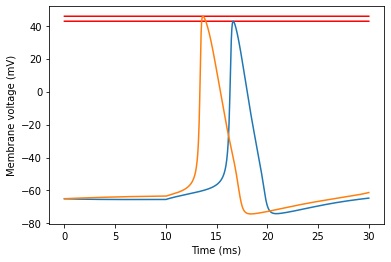

In [101]:
#Changing the value of gnabar or the density of sodium channels

for gnabar in [0.1, 0.15]:
    soma.gkbar_hh = 0.01
    soma.gnabar_hh = gnabar

    neuron.h.tstop=30

    neuron.h.run()

    plt.plot(time, max(voltage)*numpy.ones(len(time)), 'r')
    plot_tv(time, voltage, show=False)

plt.show()

When we change the value of gnabar, it changes the maximum height of the action potential. More sodium channels means the membrane reaches the Na reversal potential of 50mV much faster before the K channels can reverse the effect thus we observe a steeper and larger increase from the baseline. 

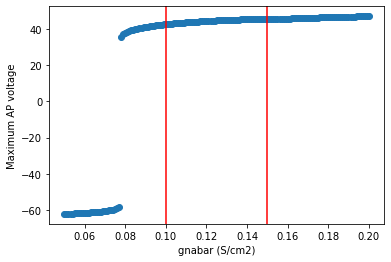

In [102]:
# Plotting multiple values of gnabar against the max height of each plot

soma.gkbar_hh = 0.01

# definitely mention critical value where state changes
# show something with percentages
# show value we were using before on plot

max_voltages = []
import numpy
gnabar_range = numpy.arange(.05, 0.2, 0.001)
for gnabar in gnabar_range:
    soma.gnabar_hh = gnabar

    neuron.h.run()

    max_voltages.append(max(voltage))

plt.plot(gnabar_range, max_voltages, 'oC0')
plt.xlabel('gnabar (S/cm2)')
plt.ylabel('Maximum AP voltage')
for xs in [0.1, 0.15]:
    plt.axvline(x=xs, color='r')
plt.show()

The two vertical lines show the parameter values we used in the previous plot.
The plotted values are the AP heights at different values of gnabar. Around 0.08 S/cm^2 there is discontinuity, it represent the point at which the neuron starts firing APs. Here we observe the all or nothing phenomena of the nature of neurons. With enough Na channel density (stimulation), the neuron fires and no matter how much one increases the density, there is very little increase in the possible max voltage (ceiling effect).

## Exercise 2

Do the same as above with a range of potassium of [.001, 0.012] and step size 0.001.

Plot the results and try to fit a linear function to the data points.
Use the following numpy function for this:

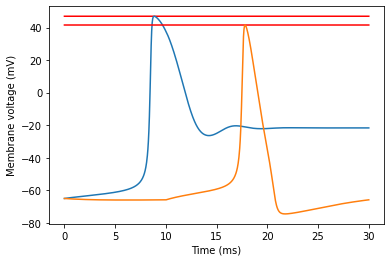

In [103]:
#Changing the value of gnabar or the density of sodium channels

for gkbar in [0.001, 0.012]:
    soma.gnabar_hh = 0.1
    soma.gkbar_hh = gkbar

    neuron.h.tstop=30

    neuron.h.run()

    plt.plot(time, max(voltage)*numpy.ones(len(time)), 'r')
    plot_tv(time, voltage, show=False)

plt.show()

Increasing the number of K channels, changes the dip and max channel in the action potential. The more K channels (orange), the slower and lesser the max AP and the lower the dip. 

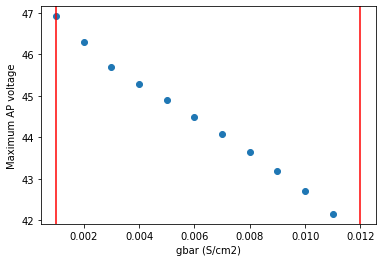

In [104]:
# Plotting multiple values of gkbar against the max height of each plot

soma.gnabar_hh = 0.1

max_voltages = []
import numpy
gkbar_range = numpy.arange(0.001, 0.012, 0.001)
for gkbar in gkbar_range:
    soma.gkbar_hh = gkbar

    neuron.h.run()

    max_voltages.append(max(voltage))

plt.plot(gkbar_range, max_voltages, 'oC0')
plt.xlabel('gbar (S/cm2)')
plt.ylabel('Maximum AP voltage')
for xs in [0.001, 0.012]:
    plt.axvline(x=xs, color='r')
plt.show()

In [105]:
#Linear Fit
linear_coef = numpy.polyfit(gkbar_range, max_voltages, 1)
print ('Linear equation max_voltage = %f*gkbar + %f' % tuple([x for x in linear_coef]))

Linear equation max_voltage = -452.072958*gkbar + 47.200992


The maximum voltage changes linearly as with the density of K channels. 

### **Adding dendrites**

Since we have built the backbone of our neuron, the soma, and as its structure represents the structure of other segments, we can now start adding the other sections of our neuron starting off by adding dendrites. **bold text**

In [109]:
#Adding a dendrite object / section and connecting it to a soma
dend = neuron.h.Section(name='dend')

dend.connect(soma)

dend.L = 400 # micron
dend.diam = 2.0 # micron
dend.nseg = 9 # number of segments in the dendritic section

In [110]:
#Add the hh mechanism to the dendrite, but making it passive (sodium and potassium channels are disabled)
#Note here that all the parts of the dendrite are also features of the soma (same dynamics in general)
dend.insert('hh')
dend.el_hh = -65 # Reversal potential leak current, mV
dend.gl_hh = 5e-4 # Leak conductance, S/cm^2

dend.gkbar_hh = 0.0
dend.gnabar_hh = 0.0

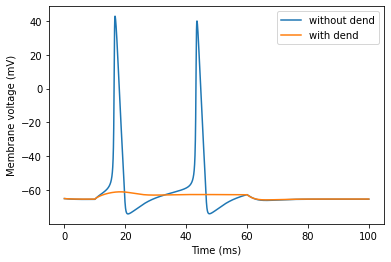

In [111]:
#Running the simulation and observing the effect of adding a dendrite to the AP
for with_dend in [False, True]:
    neuron.h.tstop = 100

    soma.gkbar_hh = 0.01
    soma.gnabar_hh = 0.1

    if with_dend:
        dend.connect(soma)
    else:
        neuron.h.disconnect(sec=dend) # disconnect dend for now
        
    neuron.h.run()

    plot_tv(time, voltage, show=False, label='with dend' if with_dend else 'without dend')

plt.legend()
plt.show()

## Exercise 3 :

**Question**: What happened ? Why are there no action potentials anymore after adding the dendrite ? What could we do to save the action potentials ?

**Answer** : With the dendrites, we observe that there are basically no action potentials. Since the dendrites have no active ion channels, they simply act to broaden the surface area of the cell without contributing to the membrane potential dynamics. Increasing the surface area of the cell indicates that a larger density of active ion channels or input current is necessary to increase and activate the action potential (the threshold observed in the sodium channel density vs. max potential would shift to the right in this case). To "save" the action potentials, we need to decrease the leak channels along the dendrites to decrease the channels that favor maintainenance of the resting membrane potential.   

**Exercise**: Try to save the APs in the soma after the dendrites are connected by changing the values of dend_ra and dend_gl in the code below:

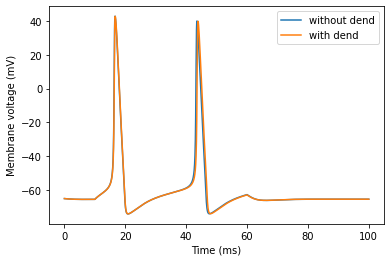

In [112]:
dend_ra = 60000
dend_gl = 1e-30

for with_dend in [False, True]:
    # For every addition of mechanism create figure show newer model
    # Lines for reversal potentials Na, K and leak
    neuron.h.tstop = 100

    soma.gkbar_hh = 0.01
    soma.gnabar_hh = 0.1

    dend.el_hh = -65 # Reversal potential leak current, mV
    dend.gl_hh = dend_gl # Leak conductance, S/cm^2
    dend.Ra = dend_ra
    
    if with_dend:
        dend.connect(soma)
    else:
        neuron.h.disconnect(sec=dend) # disconnect dend for now
        
    neuron.h.run()

    # Convert the NEURON vectors to numpy arrays
    time_py = time.to_python()
    voltage_py = voltage.to_python()

    plot_tv(time_py, voltage_py, show=False, label='with dend' if with_dend else 'without dend')

plt.legend()
plt.show()

Assuming, that we still maintain a passive dendrite, to save the AP, increasing dend.Ra and decreasing dend.gl allows the preservation of the AP. Increasing dend.Ra which is the axial resistivity of the dendrite decreases its capacitance, bringing the voltage higher. Decreasing the capacitance of the segment offsets the increase in surface area attributed to the addition of the dendrite. Meanwhile, decreasing dend.gl also helps save the AP, since it basically decreases the density of the non-voltage dependent ion channels (open ion channels that allow Na and K to slowly move in- and out- of the cell freely to re-establish the negative resting membrane potential) which allows the entire cell to reach the threshold for an AP more easily.  

Another way to "save" the AP is to simply activate the dendrite; that is add Na and K ion channels.

### **Voltage Attenuation**

While the AP is travelling along this passive dendrite, its height will attenuate. The signal becomes smaller and smaller as one goes farther and farther from the source of the potential. 

To show this, we can plot the voltage at different locations along the dendrite:

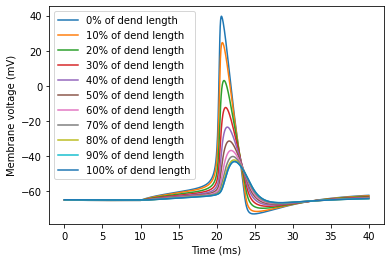

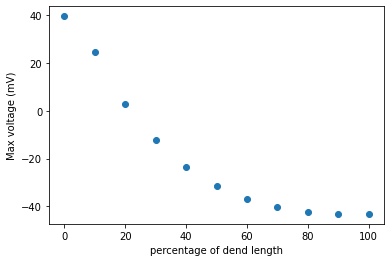

In [63]:
dend.Ra = 200
dend.gl_hh = 5e-4

voltage_dend = {}

# distances are in percentage of dendritic length
# 1.0 is at end of dendrite, 0.0 at connection with soma
distance_range = numpy.arange(0, 1.1, 0.1)
for distance in distance_range:
    voltage_dend[distance] = neuron.h.Vector()
    voltage_dend[distance].record(dend(distance)._ref_v);
 
neuron.h.tstop = 40
neuron.h.run()

for distance in distance_range:
    plot_tv(time, voltage_dend[distance], show=False, label='%.0f%% of dend length' % (distance*100))
    
plt.legend()
plt.show()

max_voltage_dend = []
for distance in distance_range:
    max_voltage_dend.append(max(voltage_dend[distance]))

plt.plot(distance_range*100, max_voltage_dend, 'o')
plt.xlabel('percentage of dend length')
plt.ylabel('Max voltage (mV)')
plt.show()

As you can observe above, the maximum voltage decreases the farther away we measure from the connection of the dendrite and soma. 

## **Adding a Synapse**
When we want to start connecting cells, we will need chemical synapses. 
In NEURON a synapse is represented as a 'point process'. Such processes are located at a specific location along the morphology and they will in general inject some current into the cell when activated (the current clamp we saw earlier was also a point process).

NEURON has several builtin synapse types. In this tutorial we will use the ExpSyn process.
This is a synapse with single exponential decay of its conductance.
The equation to calculate the current generated by this synapse is:

$$I_{syn} = g_{syn}*(V_{m} - E_{syn})$$

with

$$\frac{dg_{syn}}{dt} = \frac{-g_{syn}}{\tau}$$

$\tau$ is the time constant of the decay.

Every time an event arrives at the synapse, the conductance of the synapse is increased by its weight (in microsiemens)

$$g_{syn} = g_{syn} + weight$$


In [64]:
expsyn = neuron.h.ExpSyn(.5, sec=dend) # We add a synapse to the middle (.5) of the dendrite

To stimulate the synapse we create a NetStim object. It basically plays the role of a presynaptic cell. The attributes of this object specify how many times we want to stimulate, with which interval and when we want to start. The noise attribute determines the stochasticity of the process, 0 means completely regular firing.

In [65]:
#NetStim object as the pre-synaptic cell (pseudo-neuron where signal comes from)
netstim = neuron.h.NetStim()
netstim.interval = 5 #each signal arrives every 5ms
netstim.number = 5 # 5 signals
netstim.start = 20
netstim.noise = 0 #noise in firing

This NetStim needs to be connected to the cell. A NetCon object acts as a connector between a presynaptic and postsynaptic cell.

In [66]:
netcon = neuron.h.NetCon(netstim, expsyn)
netcon.weight[0] = 1.0

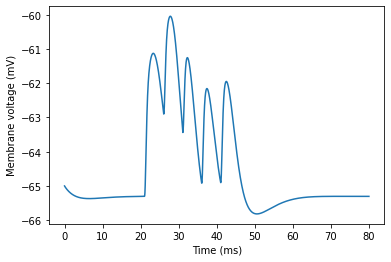

In [67]:
#Simulating

iclamp.amp = 0
neuron.h.tstop = 80
neuron.h.run()

plot_tv(time, voltage)

As you can see, there are 5 events arriving in the postsynaptic cell. Each event injects a certain current in the cell, and slowly decays afterwards. When synaptic events occur in quick success they sum up.

### **Connecting two neurons (pre-synaptic and post-synaptic)** 

In our last example we connect two cells together. 
We make a presynaptic cell and inject a current clamp into it so that it spikes. 
By connecting this cell to a postsynaptic cell, that doesn't receive a current clamp, we can make the second cell fire also.

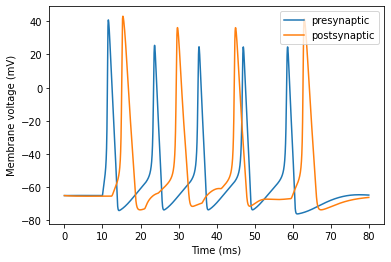

In [68]:
#Creating a new pre-synaptic cell
soma_pre = neuron.h.Section(name='soma')
soma_pre.L = 40
soma_pre.diam = 40
soma_pre.insert('hh')

iclamp_pre = neuron.h.IClamp(.5, sec=soma_pre)
iclamp_pre.amp = 1.0 # nA
iclamp_pre.delay = 10 # ms
iclamp_pre.dur = 50 # ms

time_pre = neuron.h.Vector()
voltage_pre = neuron.h.Vector()

time_pre.record(neuron.h._ref_t)
voltage_pre.record(soma_pre(.5)._ref_v);

expsyn.tau = .9 #delay time constant

#Connecting the pre-synaptic with post-synaptic as dendrite - soma type of attachment 
netcon_pre = neuron.h.NetCon(soma_pre(.5)._ref_v, expsyn, sec=soma_pre) 
netcon_pre.weight[0] = 1

#Delete prior netstim objects to make sure we're running the current neuron
if 'netstim' in locals():
    del netstim
if 'netcon' in locals():
    del netcon

neuron.h.run()

time_py = time.to_python()
voltage_py = voltage.to_python()

plot_tv(time_pre, voltage_pre, show=False, label='presynaptic')
plot_tv(time, voltage, show=False, label='postsynaptic')
plt.legend()
plt.show()

del netcon_pre

By connecting two neurons, we can now observe the phenomena of how one neuron can simulate another. We observe delayed action poitentials with different max voltages compared to the presynaptic neuron; a consequence of the differences in morphology (pre-synaptic neuron only has soma without hh properties vs. post-synaptic which has both soma + dendrite + active ion channels) and the delay in the propagation of the signal. 